# Setup

In [1]:
import ugradio
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
import os
import glob
import time
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

No module named 'rtlsdr'


In [2]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

# Data Extraction

In [46]:
def extractSdrData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=True, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data, cal_data = [[], []], [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            cal_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            cal_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data, cal_data

def subtractMean(data):
    return data - np.mean(data)


In [49]:
# First attempt at (l, b) = (120, 0)
sdr_0_prefix, sdr_1_prefix = "pol0\\", "pol1\\"
paths = [
    "obs_0_science.npy",
    "obs_1_science.npy",
    "obs_2_science.npy",
    "obs_3_science.npy",
    "obs_4_science.npy"
]
cal_paths = [
    "obs_0_cal_on.npy",
    "obs_4_cal_on.npy"
]
points = [i for i in range(0, 5)]
cal_ids = [0, 4]

sdr_0_paths = [sdr_0_prefix + path for path in paths]
sdr_1_paths = [sdr_1_prefix + path for path in paths]

sdr_0_cal_paths = [sdr_0_prefix + cal_path for cal_path in cal_paths]
sdr_1_cal_paths = [sdr_1_prefix + cal_path for cal_path in cal_paths]
    
sdr_data, cal_data = extractSdrData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=False)

In [30]:
print(sdr_data[0])
print(sdr_data[1])
print(len(sdr_data))
print(len(sdr_data[0]))
print(len(sdr_data[0][0]))

print(cal_data[0])
print(cal_data[1])
print(len(cal_data))
print(len(cal_data[0][0]))

[array([4.28117571e+07, 3.55104386e+02, 4.28677166e+02, ...,
       2.93382887e+02, 2.36470543e+02, 3.02125000e+02]), array([4.36537450e+07, 5.83425719e+02, 3.33383808e+02, ...,
       2.52594784e+02, 3.41957861e+02, 1.63000000e+02]), array([4.34894990e+07, 4.29518149e+02, 3.69191914e+02, ...,
       2.58468311e+02, 3.27462248e+02, 3.52500000e+02]), array([4.23334451e+07, 4.15703324e+02, 3.15232985e+02, ...,
       2.85402890e+02, 2.35578304e+02, 1.46625000e+02]), array([4.28089075e+07, 4.19785755e+02, 3.00020148e+02, ...,
       3.01114277e+02, 1.74719639e+02, 2.76000000e+02])]
[array([1.01131754e+08, 5.97263415e+02, 1.69888029e+02, ...,
       2.08084260e+02, 2.76590721e+02, 1.97625000e+02]), array([9.93083852e+07, 4.15264168e+02, 3.92827714e+02, ...,
       1.91183383e+02, 2.84017315e+02, 2.41250000e+02]), array([9.88325246e+07, 2.18938198e+02, 3.20051942e+02, ...,
       1.77030933e+02, 2.03309198e+02, 4.18625000e+02]), array([1.00571401e+08, 5.45219712e+02, 2.60480685e+02, ...,
  

# Power Spectrum Plotting

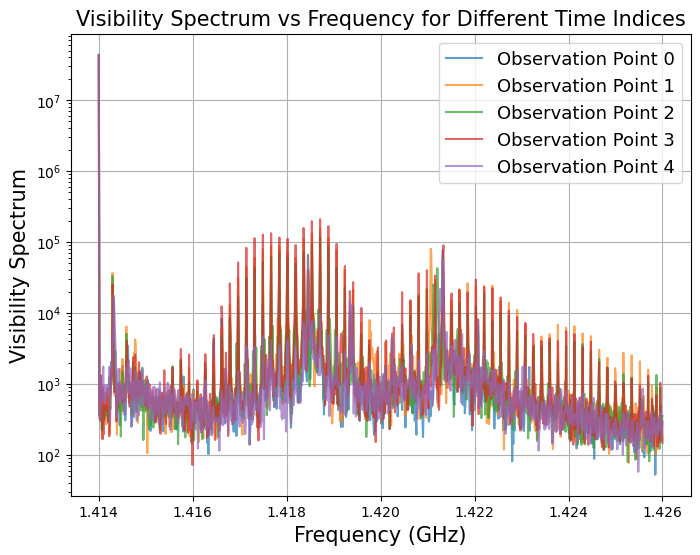

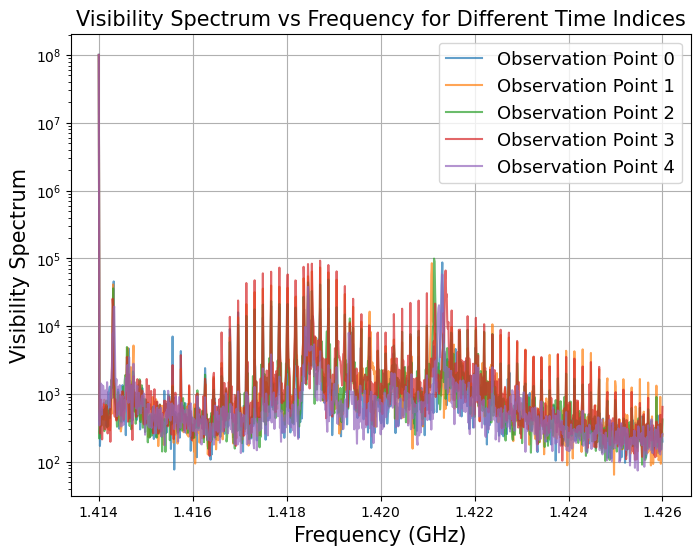

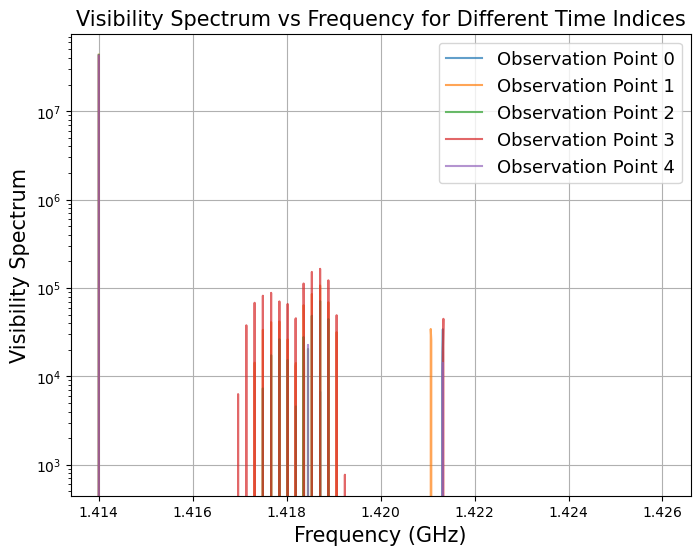

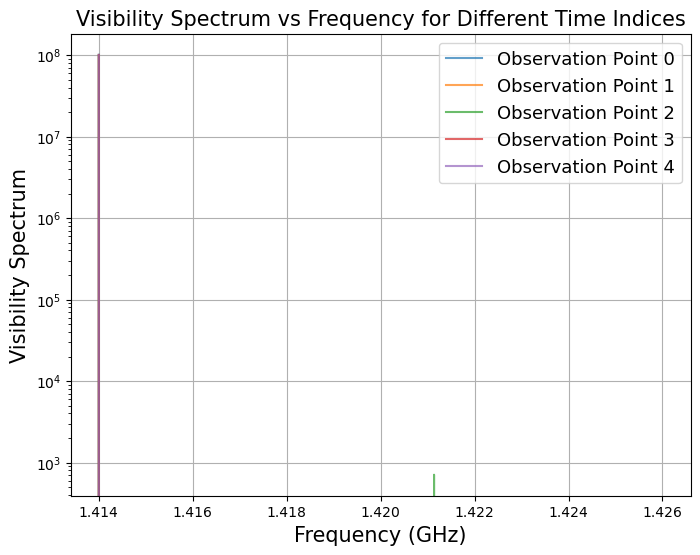

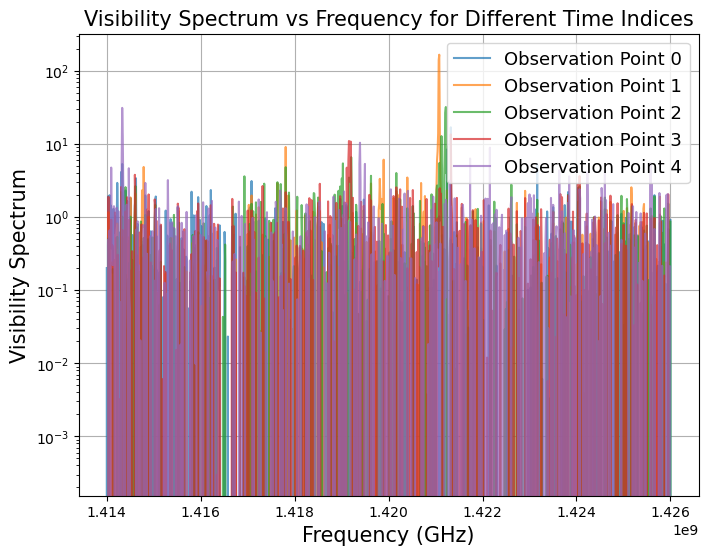

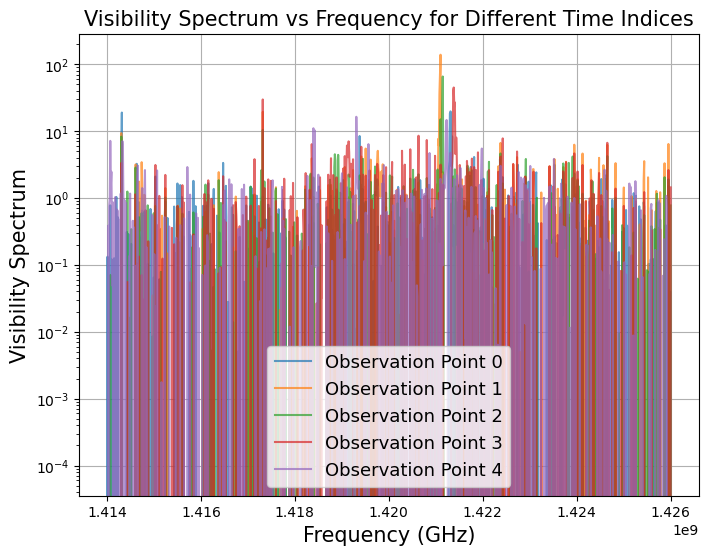

In [ ]:
LO = 1420e6
B = 12e6
low, high = LO - (B // 2), LO + (B // 2)
rf_freqs = np.linspace(low, high, 1025)

def plot_power_spectrum(data, freqs, labels, normalize=False, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    
    for spectrum, label in zip(data, labels):
        spectrum = spectrum - np.mean(spectrum) if normalize else spectrum
        plt.plot(freqs, spectrum, label=f"Observation Point {label}", alpha=0.7)
    plt.xlabel("Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()


plot_power_spectrum(sdr_data[0], rf_freqs / 1e9, points)
plot_power_spectrum(sdr_data[1], rf_freqs / 1e9, points)
plot_power_spectrum(sdr_data[0], rf_freqs / 1e9, points, normalize=True)
plot_power_spectrum(sdr_data[1], rf_freqs / 1e9, points, normalize=True)

calibrated_data_0 = [sdr_data[0][i] / cal_data[0][i // 4] for i in range(0, 5)]
calibrated_data_1 = [sdr_data[1][i] / cal_data[1][i // 4] for i in range(0, 5)]
plot_power_spectrum(calibrated_data_0, rf_freqs, points)
plot_power_spectrum(calibrated_data_1, rf_freqs, points)
plot_power_spectrum(calibrated_data_0, rf_freqs, points, normalize=True)
plot_power_spectrum(calibrated_data_1, rf_freqs, points, normalize=True)